### 分别使用单独的模型训练：
* Xception

#### 预处理数据
    由于之前已经把数据分成了dogs 文件夹和 cats 文件夹，这里就可以使用Keras中的 ImageDataGenerator 来自动处理训练数据：

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

from tqdm import *
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size=16
image_size = (299,299)

In [3]:
train_gen = ImageDataGenerator()
train_generator = train_gen.flow_from_directory('train3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                                class_mode='binary'
                                               )

valid_generator = train_gen.flow_from_directory('valid3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                               class_mode='binary')

test_generator = train_gen.flow_from_directory('test3',
                                              target_size=image_size,  # all images will be resized to 224x224
                                              batch_size=batch_size,
                                              class_mode=None)

x_train = train_generator
x_valid = valid_generator
x_test = test_generator

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
gen_ehance = ImageDataGenerator(rotation_range=5, height_shift_range=0.05, horizontal_flip=True,
                                 shear_range=0.1, channel_shift_range=10, width_shift_range=0.1)

train_generator_ehance = gen_ehance.flow_from_directory('train3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                                class_mode='binary'
                                               )
valid_generator_ehance = gen_ehance.flow_from_directory('valid3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                               class_mode='binary')
test_generator_ehance = gen_ehance.flow_from_directory('test3',
                                              target_size=image_size,  # all images will be resized to 224x224
                                              batch_size=batch_size,
                                              class_mode=None)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


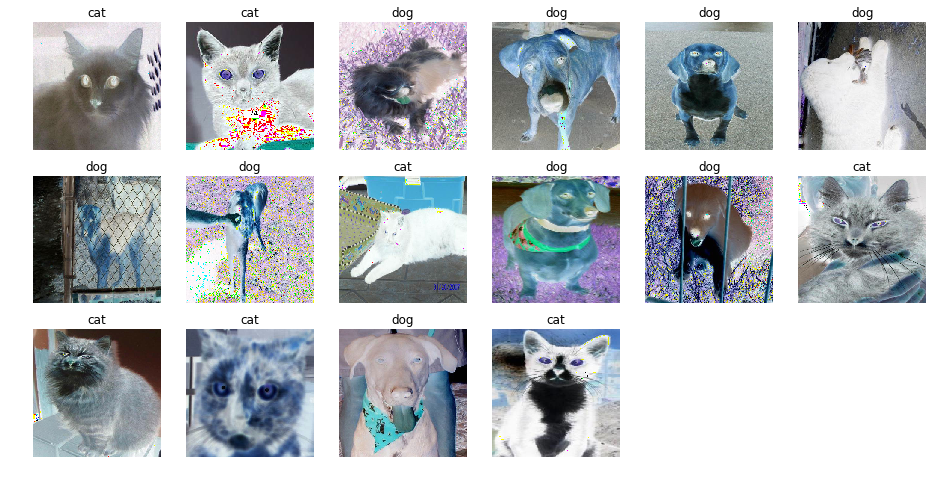

In [5]:
index, batch = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(index, batch)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

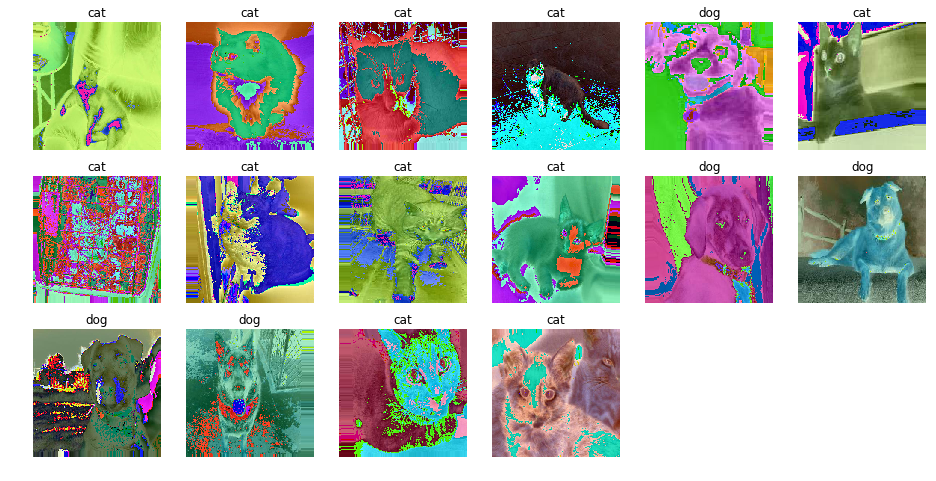

In [6]:
index, batch = train_generator_ehance.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(index, batch)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

### 引入Xception模型：

In [7]:
process_function = Lambda(xception.preprocess_input)

x = Input((image_size[0], image_size[1], 3))
x = process_function(x)

In [8]:
base_model = Xception(input_tensor=x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
#x = Dropout(0.25)(x)
x = BatchNormalization(axis=1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [10]:
from keras.callbacks import TensorBoard

tensorBoard = TensorBoard(log_dir = './logs')
model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//batch_size,
        epochs = 3,
        validation_data = valid_generator,
        validation_steps = valid_generator.samples//batch_size,
        callbacks=[tensorBoard])

Epoch 1/3
1406/1406 [==============================] - 608s 432ms/step - loss: 0.0795 - acc: 0.9723 - val_loss: 0.0388 - val_acc: 0.9884
Epoch 2/3
1406/1406 [==============================] - 511s 364ms/step - loss: 0.0590 - acc: 0.9804 - val_loss: 0.0318 - val_acc: 0.9911
Epoch 3/3
1406/1406 [==============================] - 511s 364ms/step - loss: 0.0590 - acc: 0.9799 - val_loss: 0.0544 - val_acc: 0.9831


In [11]:
model_name = 'Xception_result'
model.save('./Xception_result.h5')

In [12]:
tensorBoard = TensorBoard(log_dir = './logs')
model.fit_generator(
        train_generator_ehance,
        steps_per_epoch = train_generator_ehance.samples//batch_size,
        epochs = 3,
        validation_data = valid_generator_ehance,
        validation_steps = valid_generator_ehance.samples//batch_size,
        callbacks=[tensorBoard])

Epoch 1/3
1406/1406 [==============================] - 511s 364ms/step - loss: 0.0673 - acc: 0.9776 - val_loss: 0.0414 - val_acc: 0.9892
Epoch 2/3
1406/1406 [==============================] - 512s 364ms/step - loss: 0.0574 - acc: 0.9804 - val_loss: 0.0411 - val_acc: 0.9863
Epoch 3/3
1406/1406 [==============================] - 512s 364ms/step - loss: 0.0569 - acc: 0.9805 - val_loss: 0.0490 - val_acc: 0.9863


In [13]:
model_name = 'Xception_result_ehance'
model.save('./Xception_result_ehance.h5')

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

In [17]:
#model = load_model('Xception_result.h5', custom_objects={'process_function': Lambda(xception.preprocess_input)})

### 分别载入无数据强化model 和数据增强的model_ehance
   #### 载入未数据强化model 权重

In [18]:
process_function = Lambda(xception.preprocess_input)

x = Input((image_size[0], image_size[1], 3))
x = process_function(x)
base_model = Xception(input_tensor=x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
#x = Dropout(0.25)(x)
x = BatchNormalization(axis=1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [19]:
model.load_weights('Xception_result.h5')

#### 载入数据强化的model_weight

In [20]:
process_function = Lambda(xception.preprocess_input)

x = Input((image_size[0], image_size[1], 3))
x = process_function(x)
base_model = Xception(input_tensor=x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
#x = Dropout(0.25)(x)
x = BatchNormalization(axis=1)(x)
x = Dense(1, activation='sigmoid')(x)
model_ehance = Model(base_model.input, x)

In [21]:
model_ehance.load_weights('Xception_result_ehance.h5')

### 在测试集上进行预测

#### 未数据强化的model_weight:

In [22]:
def get_image(index):
    img = cv2.imread('test3/test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    return img

test_num = 12500

In [23]:
x_test = np.zeros((test_num, image_size[0], image_size[1], 3), dtype=np.float32)

for i in tqdm(range(0,test_num)):
    x_test[i] = get_image(i+1)

100%|██████████| 12500/12500 [01:53<00:00, 109.93it/s]


In [24]:
y_pred = model.predict(x_test, verbose=1)

12500/12500 [==============================] - 284s 23ms/step


#### 数据强化的model_ehance 进行预测

In [25]:
y_pred_ehance = model_ehance.predict(x_test, verbose=1)

12500/12500 [==============================] - 285s 23ms/step


In [26]:
y_pred = y_pred.clip(min=0.005, max=0.995)

In [27]:
y_pred_ehance = y_pred_ehance.clip(min=0.005, max=0.995)

#### 保存至csv文件中：

In [28]:
s1 = 'id,label\n'
for i, p in enumerate(y_pred):
    s1 += '%d,%f\n' % (i+1, p)

with open('result_xception.csv', 'w') as f:
    f.write(s1)

In [29]:
s2 = 'id,label\n'
for i, p in enumerate(y_pred_ehance):
    s2 += '%d,%f\n' % (i+1, p)

with open('result_xception_ehance.csv', 'w') as f:
    f.write(s2)

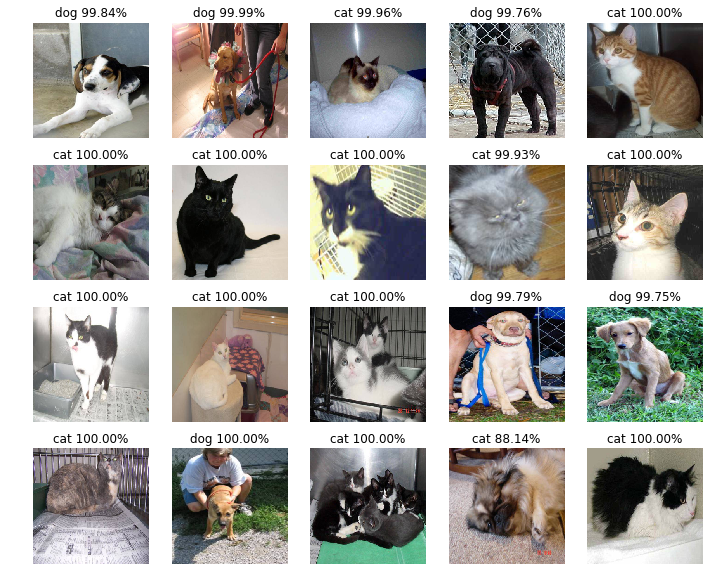

In [30]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB

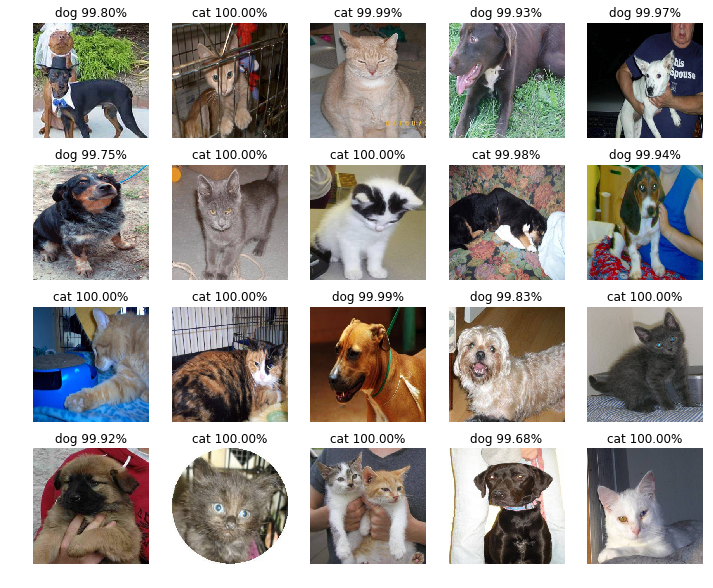

In [33]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model_ehance.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB